<a href="https://colab.research.google.com/github/Seiko-5/NLP/blob/main/Use_of_Advanced_NLP_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of Advanced NLP Techniques to Analyse the data

## Loading Libraries



In [ ]:
!pip install pyLDAvis

In [ ]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data

Load the two datasets.

In [ ]:
df1 = pd.read_csv('/content/Australia_Coronavirus_tweets.csv')

In [ ]:
# display the column names of the dataset
df1.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [ ]:
df1.head()

id      conversation_id  ...  trans_src trans_dest
0  1253873699767238656  1253808497483022336  ...        NaN        NaN
1  1253869952257449986  1253869952257449986  ...        NaN        NaN
2  1253865634070437888  1253865634070437888  ...        NaN        NaN
3  1253864245789208576  1253864245789208576  ...        NaN        NaN
4  1253861990981726209  1253861990981726209  ...        NaN        NaN

[5 rows x 34 columns]

## Preprocessing

Subseting Data

In [ ]:
df1 = df1[['date', 'tweet', 'place']]

Now we run the preprocessing.

In [ ]:
# Transform sentences into lowercase
df1['tweet'] = df1['tweet'].str.lower()

In [ ]:
# Following command is just to visualize the processed dataframe
df1.tail()

date                                              tweet place
13454  2020-02-09  remove unwanted person from photo. check out m...   NaN
13455  2020-02-09  #coronavirus #coronavirussingapore #coronaviru...   NaN
13456  2020-02-09  #coronavirus economic impact: #australia could...   NaN
13457  2020-02-09  scientists from the #unitedstates to #australi...   NaN
13458  2020-02-09  sums up federal govt..\n\nworried about budget...   NaN

Remove twitter user ids that are mentioned in the tweet text. 

In [ ]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df1['tweet'] = df1['tweet'].apply(remove_twitter_ids)
df1.tail()

date                                              tweet place
13454  2020-02-09  remove unwanted person from photo check out my...   NaN
13455  2020-02-09  coronavirus coronavirussingapore coronavirusfr...   NaN
13456  2020-02-09  coronavirus economic impact australia could be...   NaN
13457  2020-02-09  scientists from the unitedstates to australia ...   NaN
13458  2020-02-09  sums up federal govtworried about budget surpl...   NaN

## Duplicate removal

In [ ]:
# Check duplicate tweets count
duplicate_count = len(df1['tweet'])-len(df1['tweet'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df1.shape[0])

duplicate count: 692
total records before remove duplicates: 13459


In [ ]:
# drop duplicates (keep the last tweet of each of the duplicates)
df1 = df1.drop_duplicates(subset='tweet', keep="last")
print('updated record count:', df1.shape[0])

updated record count: 12767


In [ ]:
# Remove punctuations
df1['tweet'] = df1['tweet'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df1.tail()

date                                              tweet place
13454  2020-02-09  remove unwanted person from photo check out my...   NaN
13455  2020-02-09  coronavirus coronavirussingapore coronavirusfr...   NaN
13456  2020-02-09  coronavirus economic impact australia could be...   NaN
13457  2020-02-09  scientists from the unitedstates to australia ...   NaN
13458  2020-02-09  sums up federal govtworried about budget surpl...   NaN

## Stop words and domain related word removal

In [ ]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

removing the term 'not' from the stopword list for analysis.

In [ ]:
stop.remove('not')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df1['tweet'] = df1['tweet'].apply(remove_stop_words)
df1.tail(5)

date                                              tweet place
13454  2020-02-09  remove unwanted person photo check profile fiv...   NaN
13455  2020-02-09  coronavirus coronavirussingapore coronavirusfr...   NaN
13456  2020-02-09  coronavirus economic impact australia could am...   NaN
13457  2020-02-09  scientists unitedstates australia using new te...   NaN
13458  2020-02-09  sums federal govtworried budget surplus whilst...   NaN

## Remove digits

In [ ]:
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df1['tweet'] = df1['tweet'].apply(remove_digits)
df1.head()

date                                              tweet place
35  2020-04-25  3nchineseviruscoverup dr yu xiangdong criticis...   NaN
37  2020-04-25  discovered recovery coronavirus aryan race cou...   NaN
39  2020-04-25  safety common sense compliance rest good lucks...   NaN
40  2020-04-25  australia recording new cases day testing like...   NaN
41  2020-04-25  inexplicable govts coronavirus app sends data ...   NaN

## Standardization of tweets

### Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df1['tweet_stem'] = df1['tweet'].apply(stemming_function)

In [ ]:
# Compare the content vs. stemmed content
df1[['tweet', 'tweet_stem']].tail(10)

tweet                                         tweet_stem
13448  recent darpa experiments cause concern amidst ...  recent darpa experi caus concern amidst corona...
13450  hey people wake black colour stop racist coron...  hey peopl wake black colour stop racist corona...
13451  ambitious multimilliondollar project scientist...  ambiti multimilliondollar project scientist un...
13452  australians evacuated coronavirus ground zero ...  australian evacu coronaviru ground zero arriv ...
13453  great know 2nd repatriation brings citizens au...  great know 2nd repatri bring citizen australia...
13454  remove unwanted person photo check profile fiv...  remov unwant person photo check profil fiverr ...
13455  coronavirus coronavirussingapore coronavirusfr...  coronaviru coronavirussingapor coronavirusfr c...
13456  coronavirus economic impact australia could am...  coronaviru econom impact australia could among...
13457  scientists unitedstates australia using new te...  scientist unitedst australia use new technolog...
13458  sums federal govtworried budget surplus whilst...  sum feder govtworri budget surplu whilst peopl...

### Lemmatization



In [ ]:
# Download wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

In [ ]:
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

df1['tweet_lemmatized'] = df1['tweet'].apply(lemmatize_function)

Display original pre-processed sentence, stemmed sentence and lemmatized sentence.

In [ ]:
df1[['tweet', 'tweet_stem', 'tweet_lemmatized']].tail(10)

tweet  ...                                   tweet_lemmatized
13448  recent darpa experiments cause concern amidst ...  ...  recent darpa experiment cause concern amidst c...
13450  hey people wake black colour stop racist coron...  ...  hey people wake black colour stop racist coron...
13451  ambitious multimilliondollar project scientist...  ...  ambitious multimilliondollar project scientist...
13452  australians evacuated coronavirus ground zero ...  ...  australian evacuated coronavirus ground zero a...
13453  great know 2nd repatriation brings citizens au...  ...  great know 2nd repatriation brings citizen aus...
13454  remove unwanted person photo check profile fiv...  ...  remove unwanted person photo check profile fiv...
13455  coronavirus coronavirussingapore coronavirusfr...  ...  coronavirus coronavirussingapore coronavirusfr...
13456  coronavirus economic impact australia could am...  ...  coronavirus economic impact australia could am...
13457  scientists unitedstates australia using new te...  ...  scientist unitedstates australia using new tec...
13458  sums federal govtworried budget surplus whilst...  ...  sum federal govtworried budget surplus whilst ...

[10 rows x 3 columns]

Lemmatized algorithm seems to be working better in this case.


## Common and rare word analysis (Word frequency analysis)

Let us look at the most occuring words 

In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df1['tweet_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words 
word_frequency[:50]

australia               13320
coronavirus             12681
covid19                  5251
case                     1515
china                    1287
pandemic                 1101
not                      1054
people                   1048
auspol                   1025
new                      1002
uk                        920
usa                       918
u                         915
australian                880
death                     775
canada                    711
via                       703
italy                     673
sydney                    610
health                    597
covid                     577
country                   572
virus                     550
news                      549
coronavirusaustralia      543
japan                     541
time                      535
world                     528
lockdown                  528
travel                    523
day                       516
france                    488
government                487
home      

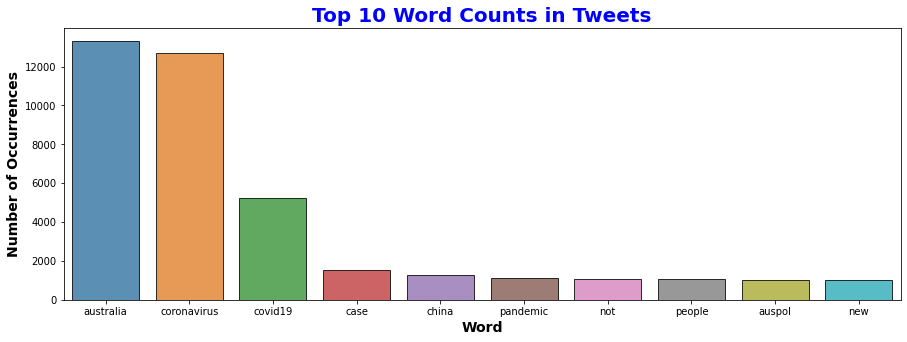

In [ ]:
# Visualize the top word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8,edgecolor = 'black')

plt.title('Top 10 Word Counts in Tweets',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Occurrences', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words in 4 ways.

In [ ]:
from PIL import Image
from wordcloud import WordCloud

### Remove common words

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["australia", "coronavirus", "covid19", "pandemic", "australian",
                       "covid","coronavirusaustralia","coronavirusaus","coronavirusoutbreak",
                       "covid19australia","australias","covid2019","covid19aus","corona","virus",
                       "coronaoutbreak","ncov2019"]

In [ ]:
# Remove common Tweet
df1['tweet_lemmatized'] = df1['tweet_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df1.head(5)

date  ...                                   tweet_lemmatized
35  2020-04-25  ...  3nchineseviruscoverup dr yu xiangdong criticis...
37  2020-04-25  ...  discovered recovery aryan race country iran ge...
39  2020-04-25  ...  safety common sense compliance rest good lucks...
40  2020-04-25  ...  recording new case day testing like mad death ...
41  2020-04-25  ...  inexplicable govts app sends data amazondatapr...

[5 rows x 5 columns]

In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df1['tweet_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words
word_frequency[:50]

case          1515
china         1287
not           1054
people        1048
auspol        1025
new           1002
uk             920
usa            918
u              915
death          775
canada         711
via            703
italy          673
sydney         610
health         597
country        572
news           549
japan          541
time           535
world          528
lockdown       528
travel         523
day            516
france         488
government     487
home           466
spread         465
need           450
get            447
india          443
confirmed      434
say            430
like           416
outbreak       410
positive       407
germany        364
one            360
toilet         356
iran           352
wuhan          351
go             347
update         343
paper          341
nsw            334
due            330
dont           328
test           325
first          323
week           308
place          304
dtype: int64

In [ ]:
# Save the pre-process data
# df1.to_csv('Preprocess_Tweets.csv')

### Word Cloud 01

In this Word Cloud frequency of all the worlds were taken in to consideration.

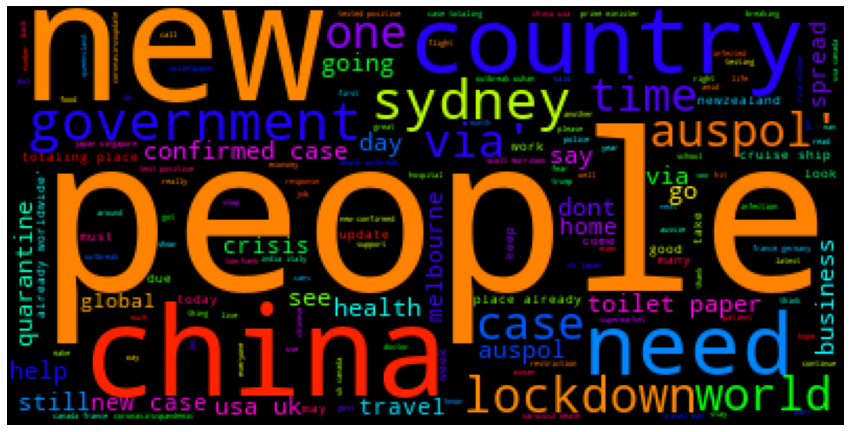

In [ ]:
corpus = list(df1['tweet_lemmatized'])

wordcloud = WordCloud(background_color='black',colormap="hsv",
                      random_state=42).generate(str(corpus))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('Word_Cloud_01.png', dpi=800)
#files.download('Word_Cloud_01.png')
plt.show()

### Word Cloud 02

In here top 500 words were taken into consideration

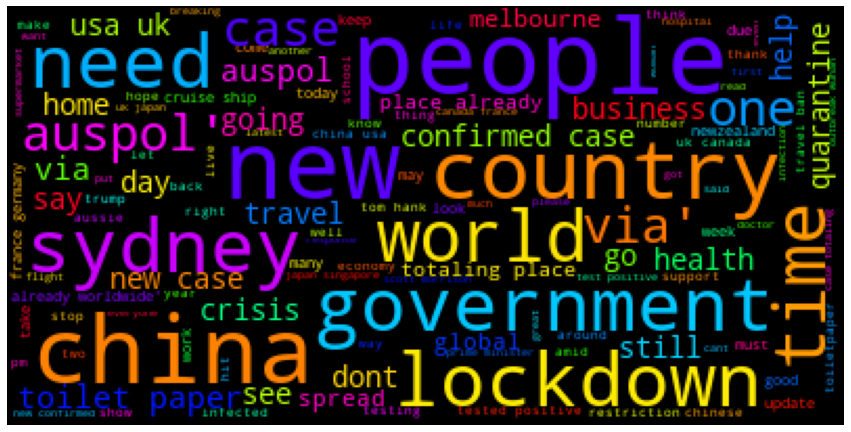

In [ ]:
corpus = list(df1['tweet_lemmatized'])

wordcloud = WordCloud(background_color='black',colormap="hsv",max_words=500,max_font_size=50,
                      random_state=42).generate(str(corpus))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('Word_Cloud_02.png', dpi=800)
#files.download('Word_Cloud_02.png')
plt.show()

### Word Cloud 03

In here all the words were taken into concideration and filter it using giving max_fount_size and min_fount_size to capture the words in bethween size 50 and 10 to get a clear view of the above plot.

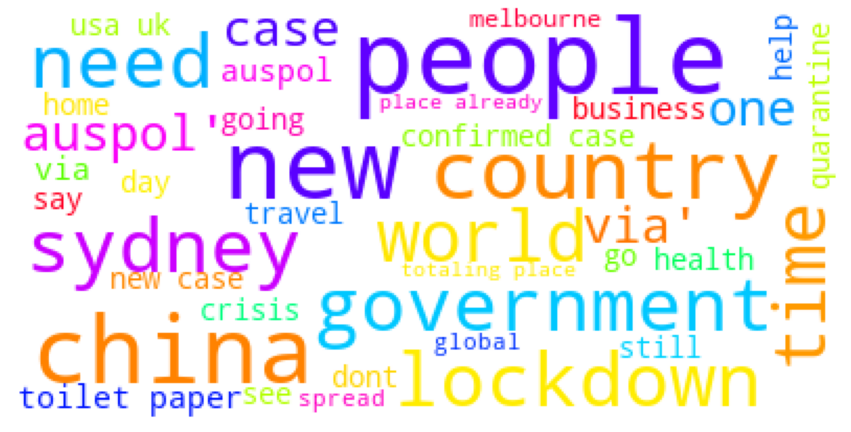

In [ ]:
corpus = list(df1['tweet_lemmatized'])

wordcloud = WordCloud(background_color='white',colormap="hsv",max_font_size=50,min_font_size=10,
                      random_state=42).generate(str(corpus))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('Word_Cloud_03.png', dpi=800)
#files.download('Word_Cloud_03.png')
plt.show()

### Word Cloud 4

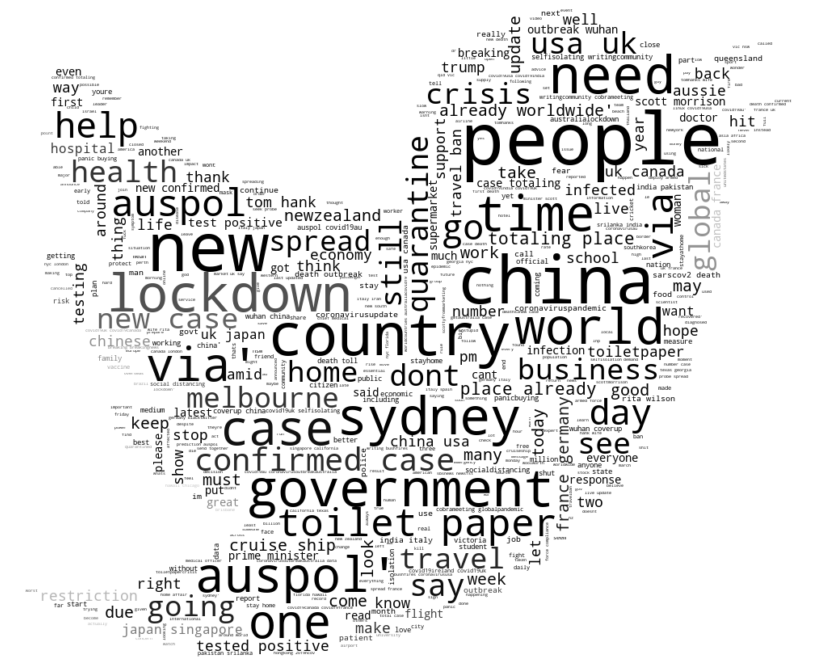

In [ ]:
from wordcloud import WordCloud,ImageColorGenerator

## join all documents in corpus
corpus = list(df1['tweet_lemmatized'])
mask = np.array(Image.open("/content/twitter_mask.png"))
wc = WordCloud(background_color="white", max_words=800, mask=mask,
               max_font_size=90, random_state=42)
wc.generate(str(corpus))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,12])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
#plt.savefig('Word_Cloud_04.png', dpi=800)
#files.download('Word_Cloud_04.png')
_=plt.show()

## Bigrams and Trigrams

### Bigrams

In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create bag of word feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
bigrams_covid = get_ngrams(df1['tweet_lemmatized'].tolist(), ngram_range=(2, 2))


Convert bigrams of datasets to a dataframe with column names bi-gram and frequency.

In [ ]:
bigrams_covid_df = pd.DataFrame(bigrams_covid)
bigrams_covid_df.columns=["Bi-gram", "Freq"]

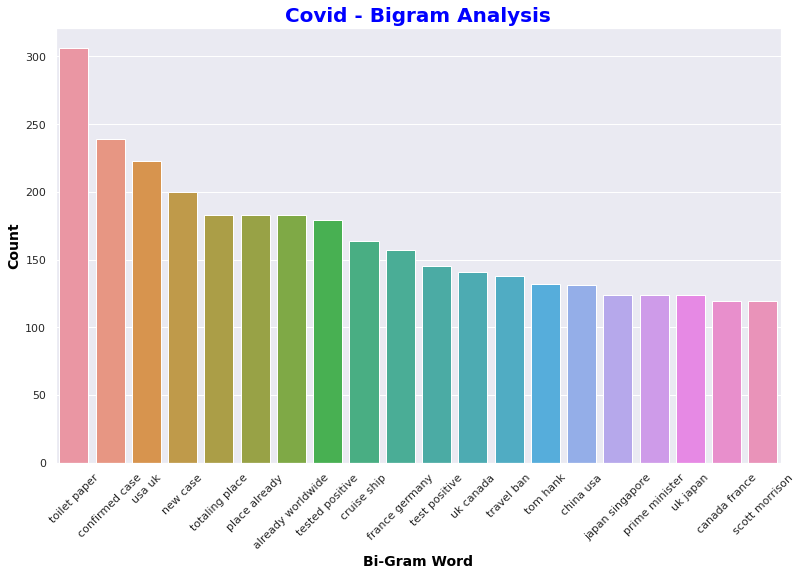

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot( x="Bi-gram", y="Freq",data=bigrams_covid_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels

plt.title('Covid - Bigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Bi-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('Covid_Bigram_Analysis.png', dpi=800)
#files.download('Covid_Bigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Bigrams**

In [ ]:
new_bigrams_covid_df= pd.concat([bigrams_covid_df['Bi-gram'].str.split(' ', expand=True)], axis=1)
new_bigrams_covid_df.columns=["word1", "word2"]

In [ ]:
#Bigrams related to "Case" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'case']

word1 word2
1        confirmed  case
3              new  case
68      deaths3new  case
100         number  case
104          total  case
114   gmtaustralia  case
241         global  case
288          first  case
339          march  case
508          surge  case
511     deaths5new  case
680         latest  case
701           jump  case
912      recovered  case
1130          rise  case
1230         spike  case
1244        active  case
1250         death  case
1351     worldwide  case
1497        people  case
1587      positive  case
1710           nsw  case
1713       country  case
1734       another  case
1752      reported  case
1952          case  case

In [ ]:
#Bigrams related to "china" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'china']

word1  word2
26         wuhan  china
33       coverup  china
202          ccp  china
281         iran  china
448     pressure  china
510      outside  china
580         asia  china
679       africa  china
692     mainland  china
734          via  china
846      student  china
886        italy  china
923       russia  china
1013   covidiots  china
1146    collapse  china
1179         ban  china
1222        like  china
1276        link  china
1287       world  china
1348        made  china
1578     support  china
1634         usa  china
1717      spread  china
1732  southkorea  china
1735      canada  china
1744     oceania  china
1822         not  china
1866        note  china
1990       south  china

In [ ]:
#Bigrams related to "not" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word1'] == 'not']

word1    word2
62     not     time
199    not     take
345    not   travel
561    not       go
637    not     sure
742    not     even
784    not     good
815    not     send
1066   not   enough
1227   not   spread
1261   not  allowed
1367   not      yet
1372   not   immune
1571   not     want
1637   not   taking
1706   not    panic
1822   not    china
1826   not      get
1855   not    going
1885   not     make
1936   not  working

In [ ]:
#Bigrams related to "death" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'death']

word1  word2
27     sarscov2  death
46          new  death
59         case  death
78        first  death
210       total  death
1002        1st  death
1082     report  death
1258  infection  death
1299     global  death
1395       iran  death
1612     number  death
1654      daily  death
1808     second  death

In [ ]:
#Bigrams related to "place" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'place']

word1  word2
4        totaling  place
745           put  place
852   restriction  place
1133         cafe  place
1558       public  place

In [ ]:
#Bigrams related to "worldwide" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'worldwide']

word1      word2
6     already  worldwide
1494     case  worldwide

In [ ]:
#Bigrams related to "disease" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'disease']

word1    word2
737       spread  disease
1051  quarantine  disease

In [ ]:
#Bigrams related to "country" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'country']

word1    word2
361     across  country
474      every  country
616   entering  country
869      first  country
948       case  country
1050      many  country
1205     third  country
1288     lucky  country
1301      home  country
1425  arriving  country
1465    people  country
1757  epidemic  country
1838       two  country

In [ ]:
#Bigrams related to "health" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'health']

word1   word2
250        world  health
256       public  health
321       threat  health
486          nsw  health
941          via  health
944     2019ncov  health
1514      mental  health
1516       chief  health
1580     protect  health
1641  government  health
1652      people  health
1778      global  health
1886   frontline  health
1967  positiveuk  health

In [ ]:
#Bigrams related to "spread" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'spread']

word1   word2
86        probe  spread
170        stop  spread
205        slow  spread
400     prevent  spread
676        curb  spread
910     contain  spread
1115       halt  spread
1227        not  spread
1274    slowing  spread
1486  community  spread
1680      limit  spread
1780       fear  spread

In [ ]:
#Bigrams related to "lockdown" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word2'] == 'lockdown']

word1     word2
261        scomo  lockdown
812           go  lockdown
1012  quarantine  lockdown
1374     country  lockdown
1553  nationwide  lockdown
1585    complete  lockdown
1695    stayhome  lockdown
1821        amid  lockdown

In [ ]:
#Bigrams related to "positive" term
new_bigrams_covid_df.loc[new_bigrams_covid_df['word1'] == 'positive']

word1           word2
834   positive           novel
983   positive  coronavirusthe
1587  positive            case
1796  positive        tomhanks
1897  positive             via
1977  positive            hank

### Trigrams

In [ ]:
#Most frequently occuring Tri-grams
def get_trigrams(corpus):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
trigrams_covid = get_ngrams(df1['tweet_lemmatized'].tolist(), ngram_range=(3, 3))

In [ ]:
trigrams_covid_df = pd.DataFrame(trigrams_covid)
trigrams_covid_df.columns=["Tri-gram", "Freq"]

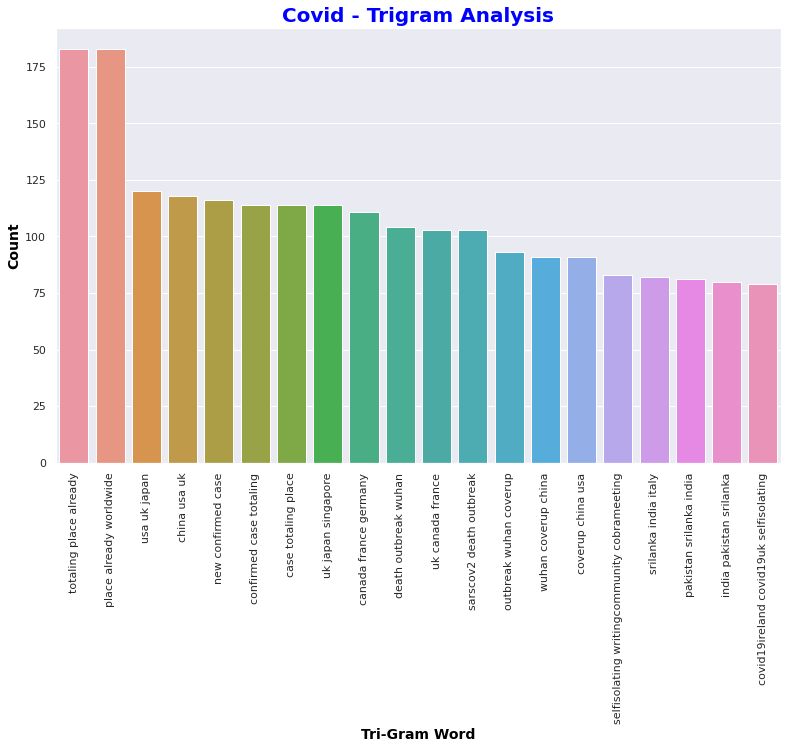

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_covid_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)

plt.title('Covid - Trigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Tri-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('Covid_Trigram_Analysis.png', dpi=800)
#files.download('Covid_Trigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Trigrams**

In [ ]:
new_trigrams_covid_df= pd.concat([trigrams_covid_df['Tri-gram'].str.split(' ', expand=True)], axis=1)
new_trigrams_covid_df.columns=["word1", "word2","word3"]

In [ ]:
#Trigrams related to "positive" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word3'] == 'positive']

word1    word2     word3
118        wilson   tested  positive
141        wilson     test  positive
201          wife   tested  positive
217    ritawilson   tested  positive
245    ritawilson     test  positive
272          wife     test  positive
392      minister     test  positive
536     announced   tested  positive
540        dutton     test  positive
807        affair     test  positive
973        sydney   tested  positive
974        people   tested  positive
1045     minister   tested  positive
1063     hospital  testing  positive
1107          man   tested  positive
1109       latest     test  positive
1540         said   tested  positive
1544  peterdutton   tested  positive
1545       dutton   tested  positive
1574         rita   tested  positive
1588      student   tested  positive
1589      student     test  positive
1800       player     test  positive
1848    karnataka   tested  positive
1862    passenger     test  positive
1927       theyve   tested  positive

In [ ]:
#Trigrams related to "china" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word3'] == 'china']

word1      word2  word3
13               wuhan    coverup  china
151           outbreak      wuhan  china
170              spain       iran  china
331             adding   pressure  china
372               asia     africa  china
516            instead   collapse  china
673             travel        ban  china
840            belgium      wuhan  china
1018               usa    denmark  china
1167                eu       asia  china
1180     coronarvirues      wuhan  china
1203             china       note  china
1295               via  covidiots  china
1299            norway    belgium  china
1403            europe     russie  china
1449              asia    oceania  china
1586  skincareproducts      wuhan  china
1668            canada      italy  china
1752           medical     supply  china
1764           florida       polo  china
1977             sends     export  china
1982              head   austcham  china

In [ ]:
#Trigrams related to "not" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word1'] == 'not']

word1    word2       word3
133    not     time    politics
181    not     take       graph
512    not     take  medication
653    not   travel    overseas
1398   not     send     athlete
1487   not   travel    anywhere
1847   not  closing      school
1857   not   caring      spread
1931   not    entry        ride

In [ ]:
#Trigrams related to "death" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word2'] == 'death']

word1  word2                word3
11                  sarscov2  death             outbreak
55                       new  death            confirmed
380                     case  death         coronacrisis
644                     iran  death                 toll
646                    total  death  coronaviruspandemic
696                     case  death            recovered
1113                 54total  death                 2nsw
1117                   first  death            confirmed
1212                national  death                 toll
1278                   daily  death                 toll
1893  today16critical1nsw134  death                qld63
1958                  second  death            95yearold

In [ ]:
#Trigrams related to "spread" term
new_trigrams_covid_df.loc[new_trigrams_covid_df['word3'] == 'spread']

word1    word2   word3
39             seek    probe  spread
859   investigation   origin  spread
1344           help     stop  spread
1834           next  hotspot  spread
1857            not   caring  spread

## Sentiment Analysis

In [ ]:
# Extract sentiments from the tweets using both polarity and subjectivity
df1['polarity'] = df1['tweet_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
df1['subjectivity'] = df1['tweet_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [ ]:
# Display first 50 tweets with respective sentiment value
df1[['tweet_lemmatized', 'polarity','subjectivity' ]].head(10)


tweet_lemmatized  polarity  subjectivity
35  3nchineseviruscoverup dr yu xiangdong criticis...  0.000000      0.000000
37  discovered recovery aryan race country iran ge... -0.150000      0.504167
39  safety common sense compliance rest good lucks...  0.200000      0.550000
40  recording new case day testing like mad death ...  0.142273      0.680909
41  inexplicable govts app sends data amazondatapr... -0.600000      0.900000
42  newzealand mark anzacday driveway household ur...  0.156250      0.416667
43  everytime trump speaks thank lord parent immig...  0.000000      0.000000
44  auspol btw germany run scientist run scomo com...  0.000000      0.000000
45  drug u fda finally issue warning danger chloro...  0.000000      1.000000
46  baked anzac biscuitsanzacbiscuits anzacathome2...  0.000000      0.000000

Aggregate the sentiment value (using mean)

In [ ]:
df_polarity_covid_date_wise = df1.groupby(['date'])['polarity'].mean().reset_index(name='mean_polarity_covid')


In [ ]:
df_subjectivity_covid_date_wise = df1.groupby(['date'])['subjectivity'].mean().reset_index(name='mean_subjectivity_covid')

Plot sentiment over time.

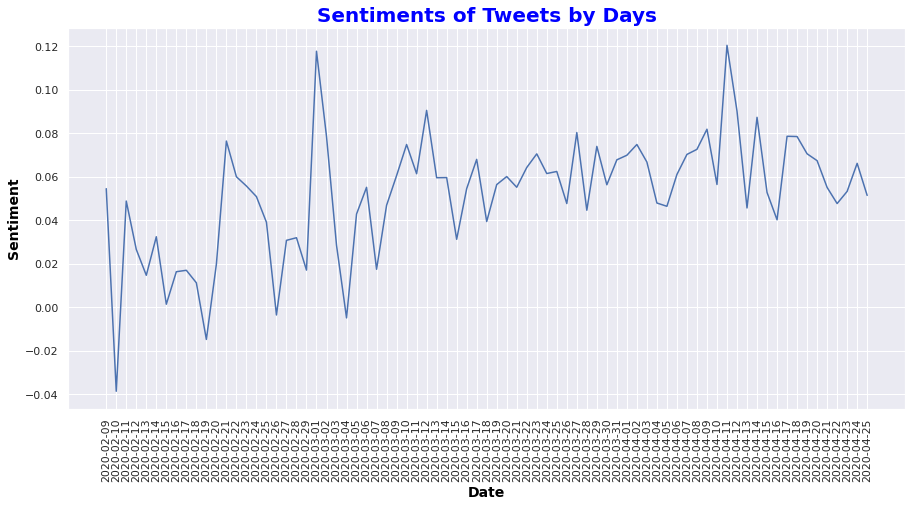

In [ ]:
# Plot twitter sentimet timeline over each provider using polarity

plt.figure(figsize=(15, 7)) 
sns.lineplot(x='date', y='mean_polarity_covid', legend='full', data=df_polarity_covid_date_wise)


plt.title('Sentiments of Tweets by Days',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Sentiment', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Date', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xticks(rotation=90)


#plt.savefig('Sentiments_Tweets_Days_polarity.png', dpi=800)
#files.download('Sentiments_Tweets_Days_polarity.png')
plt.show()


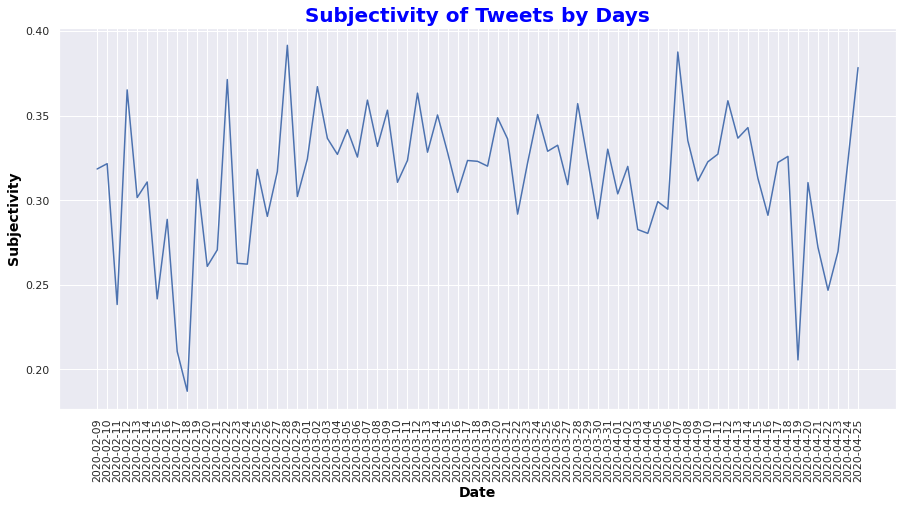

In [ ]:
# Plot twitter sentimet timeline over each provider using subjectivity

plt.figure(figsize=(15, 7)) 
sns.lineplot(x='date', y='mean_subjectivity_covid', legend='full', data=df_subjectivity_covid_date_wise)


plt.title('Subjectivity of Tweets by Days',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Subjectivity', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Date', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xticks(rotation=90)


#plt.savefig('Subjectivity_Tweets_Days.png', dpi=800)
#files.download('Subjectivity_Tweets_Days.png')
plt.show()

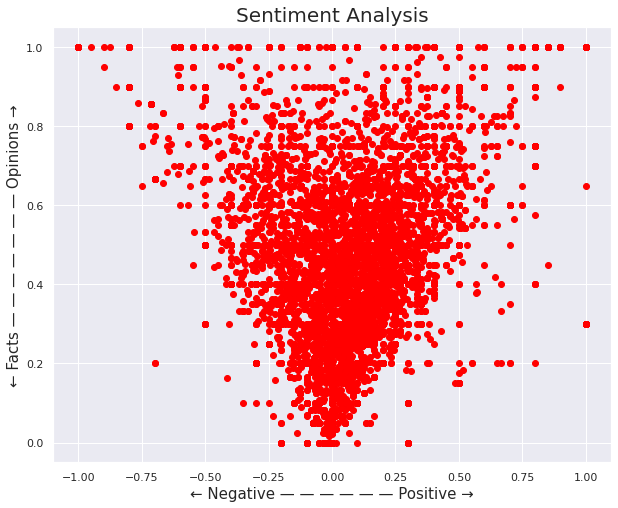

In [ ]:
# Let’s plot the results of polarity and Subjectivity together. 

plt.rcParams['figure.figsize'] = [10, 8]
for index, tweet_lemmatized in enumerate(df1.index):
 x = df1.polarity.loc[tweet_lemmatized]
 y = df1.subjectivity.loc[tweet_lemmatized]
 plt.scatter(x, y, color='Red')
 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()



In [ ]:
# Creating function for calculating positive, negative and neutral

def ratio(x):  
  if x > 0.5:
   return 'Extream Positive'
  elif x > 0:
   return 'Positive'
  elif x == 0:
   return 'Neutral'
  elif x > -0.50:
   return 'Negative'
  else:
   return 'Extream Negative'

df1['Sentiment'] = df1['polarity'].apply(ratio)

In [ ]:
#Count of sentiments

df1['Sentiment'].value_counts()

Neutral             5141
Positive            4692
Negative            2260
Extream Positive     372
Extream Negative     302
Name: Sentiment, dtype: int64

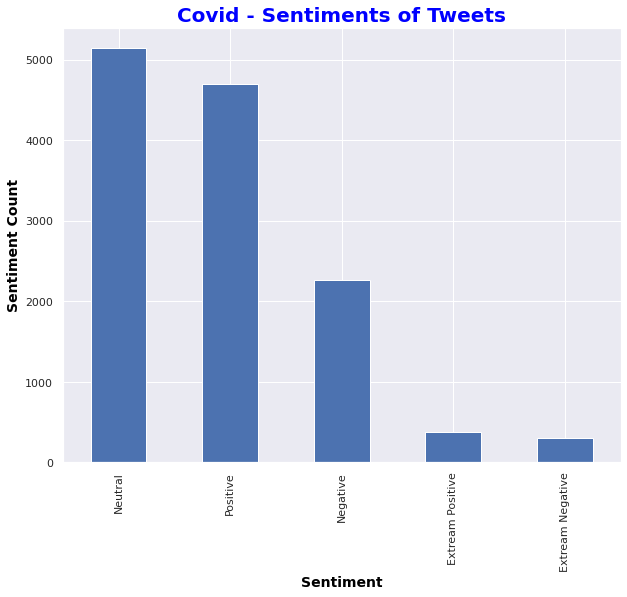

In [ ]:
#Plotting Sentiments

df1['Sentiment'].value_counts().plot(kind = 'bar')

plt.title('Covid - Sentiments of Tweets', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Sentiment', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Sentiment Count', fontweight='bold', color = 'black', fontsize='14')  


#plt.savefig('Sentiment_Analysis2.png', dpi=800)
#files.download('Sentiment_Analysis2.png')
plt.show()


## Topic Modeling

In [ ]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


Now we will create the text corpus.

In [ ]:
# Convert the tweets as the text corpus.
corpus = list(df1['tweet_lemmatized'])

In [ ]:
# Tokanization
covid_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(covid_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'covid.dict'))

2020-05-12 03:50:34,905 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-12 03:50:35,099 : INFO : adding document #10000 to Dictionary(24372 unique tokens: ['3nchineseviruscoverup', 'activism', 'china', 'communist', 'critic']...)
2020-05-12 03:50:35,154 : INFO : built Dictionary(28473 unique tokens: ['3nchineseviruscoverup', 'activism', 'china', 'communist', 'critic']...) from 12767 documents (total 175091 corpus positions)
2020-05-12 03:50:35,157 : INFO : saving Dictionary object under /tmp/covid.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-05-12 03:50:35,173 : INFO : saved /tmp/covid.dict


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'3nchineseviruscoverup': 0, 'activism': 1, 'china': 2, 'communist': 3, 'critic': 4, 'criticised': 5, 'demoteda': 6, 'dr': 7, 'expulsion': 8, 'facing': 9, 'party': 10, 'pictwittercomabyc7lldjd': 11, 'response': 12, 'still': 13, 'student': 14, 'targeting': 15, 'tell': 16, 'xiangdong': 17, 'yu': 18, 'arabia': 19, 'aryan': 20, 'austria': 21, 'badly': 22, 'country': 23, 'discovered': 24, 'fastbut': 25, 'germany': 26, 'hardship': 27, 'iran': 28, 'israel': 29, 'like': 30, 'mixed': 31, 'mostly': 32, 'pictwittercomm4cwjpwhrm': 33, 'poor': 34, 'qatar': 35, 'race': 36, 'recover': 37, 'recovering': 38, 'recovery': 39, 'russia': 40, 'saudi': 41, 'suffering': 42, 'trumpvirus': 43, 'usa': 44, 'common': 45, 'compliance': 46, 'france': 47, 'good': 48, 'india': 49, 'italy': 50, 'lockdown2': 51, 'lockdownextension': 52, 'lucksaturdaythoughts': 53, 'pictwittercomxrh917fcgq': 54, 'rest': 55, 'safety': 56, 'saturdaymotivation': 57, 'sense': 58, 'spain': 59, 'stayathome': 60, 'stayhome': 61, 'stayhomestaysa

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in covid_texts]

In [ ]:
# Corpus in machine readable format.
print(corpus)

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(2, 1), (26, 1), (28, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [(30, 2), (32, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1)], [(79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1)], [(66, 1), (72, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2

### Generate the topic model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2020-05-12 03:50:59,751 : INFO : collecting document frequencies
2020-05-12 03:50:59,752 : INFO : PROGRESS: processing document #0
2020-05-12 03:50:59,794 : INFO : PROGRESS: processing document #10000
2020-05-12 03:50:59,803 : INFO : calculating IDF weights for 12767 documents and 28472 features (168443 matrix non-zeros)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

**Defining Topics Using LDA model**

In [ ]:
total_topics = 10

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2020-05-12 03:51:11,412 : INFO : using symmetric alpha at 0.1
2020-05-12 03:51:11,413 : INFO : using symmetric eta at 0.1
2020-05-12 03:51:11,427 : INFO : using serial LDA version on this node
2020-05-12 03:51:11,478 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 12767 documents, updating model once every 2000 documents, evaluating perplexity every 12767 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-12 03:51:11,479 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-05-12 03:51:11,480 : INFO : PROGRESS: pass 0, at document #2000/12767
2020-05-12 03:51:12,373 : INFO : merging changes from 2000 documents into a model of 12767 documents
2020-05-12 03:51:12,432 : INFO : topic #1 (0.100): 0.013*"china" + 0.013*"via" + 0.007*"canada" + 0.006*"government" + 0.006*"uk" + 0.006*"people" + 0.005*"lockdown" + 0.005*"world" + 0.005*"

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.



In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=5)

[(0,
  '0.023*"auspol" + 0.016*"china" + 0.010*"people" + 0.008*"not" + 0.008*"day"'),
 (1,
  '0.019*"china" + 0.014*"via" + 0.013*"people" + 0.012*"toilet" + 0.011*"panic"'),
 (2,
  '0.014*"japan" + 0.011*"south" + 0.010*"india" + 0.008*"coronavirusupdate" + 0.008*"new"'),
 (3,
  '0.027*"georgia" + 0.012*"usa" + 0.011*"not" + 0.010*"florida" + 0.009*"china"'),
 (4,
  '0.016*"cdc" + 0.011*"china" + 0.011*"usa" + 0.008*"wife" + 0.008*"sarscov2"'),
 (5,
  '0.050*"case" + 0.039*"death" + 0.031*"coverup" + 0.027*"new" + 0.021*"confirmed"'),
 (6,
  '0.024*"travel" + 0.023*"ban" + 0.013*"cruise" + 0.011*"ship" + 0.011*"positive"'),
 (7,
  '0.043*"china" + 0.029*"japan" + 0.025*"wuhan" + 0.022*"singapore" + 0.022*"hongkong"'),
 (8,
  '0.011*"tom" + 0.011*"hank" + 0.008*"rita" + 0.008*"u" + 0.006*"contact"'),
 (9,
  '0.023*"texas" + 0.011*"toilet" + 0.011*"paper" + 0.008*"sarscov2" + 0.007*"buy"')]

**Defining Topics Using NMF model**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;

In [ ]:
from sklearn.preprocessing import normalize;

In [ ]:
from sklearn.decomposition import NMF;

In [ ]:
nmf_df = df1['tweet_lemmatized']

In [ ]:
#obtain a Counts design matrix. Because the size of the matrix will be large, we can set the max_features to 5000.
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(nmf_df);

In [ ]:
#set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
#normalize the TfIdf values so each row has unit length.
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=total_topics, init='nndsvd');

In [ ]:
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(total_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-6 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model,6)

Topic # 01  Topic # 02  ...        Topic # 09   Topic # 10
0   totaling        case  ...            sydney          new
1  worldwide       total  ...          lockdown        south
2    already   confirmed  ...         melbourne         wale
3      place  deaths3new  ...  socialdistancing    casesand1
4  confirmed   recovered  ...               nsw  restriction
5        new     updated  ...         meanwhile      zealand

[6 rows x 10 columns]

## Interactive Topic Analyzer With LDA

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2020-05-12 03:52:22,689 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  49.195435
3       0.648955  71.707100       2        1   9.970639
7      71.019684   9.971006       3        1   5.831879
4       3.785981  33.185135       4        1   5.001316
5     -42.666500  -9.222070       5        1   5.000877
2      -3.621689 -43.526516       6        1   5.000257
1      -3.632402  -4.171708       7        1   5.000194
8     -36.584400  35.804413       8        1   4.999989
6      44.391380  50.615383       9        1   4.999708
9      40.235809 -31.591665      10        1   4.999700, topic_info=         Term        Freq       Total Category  logprob  loglift
2       china  176.000000  176.000000  Default  30.0000  30.0000
64       case   48.000000   48.000000  Default  29.0000  29.0000
470     wuhan   60.000000   60.000000  Default  28.0000  28.0000
9342  georgia   34.000000   34.000000  Default  27.0000  27.0000
67      death   39.000000   39.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
351    people    2.832642   97.202858  Topic10  -5.4175  -0.5398
118    auspol    2.419008  158.634598  Topic10  -5.5754  -1.1875
113       not    2.291348   84.301064  Topic10  -5.6296  -0.6095
1856   impact    2.104953   36.964870  Topic10  -5.7145   0.1301
863       hit    2.078877   21.290611  Topic10  -5.7269   0.6694

[694 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
4742       3  1.350531         14day
24696      1  0.298187  1coronavirus
24696      5  0.596374  1coronavirus
25391      5  0.645559           1nt
11057      1  0.727550      2019ncov
...      ...       ...           ...
11760      7  1.355826            xi
2176       6  0.655857     yesterday
26901      9  0.906902      yokohama
1991       2  0.727545         youre
1991      10  0.242515         youre

[1077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 5, 6, 3, 2, 9, 7, 10])

## Tweet Stats

### Analysis of Tweets Location

In [ ]:
#Identifying unique locations (Exluding NaN values)
df1['place'].nunique()

12

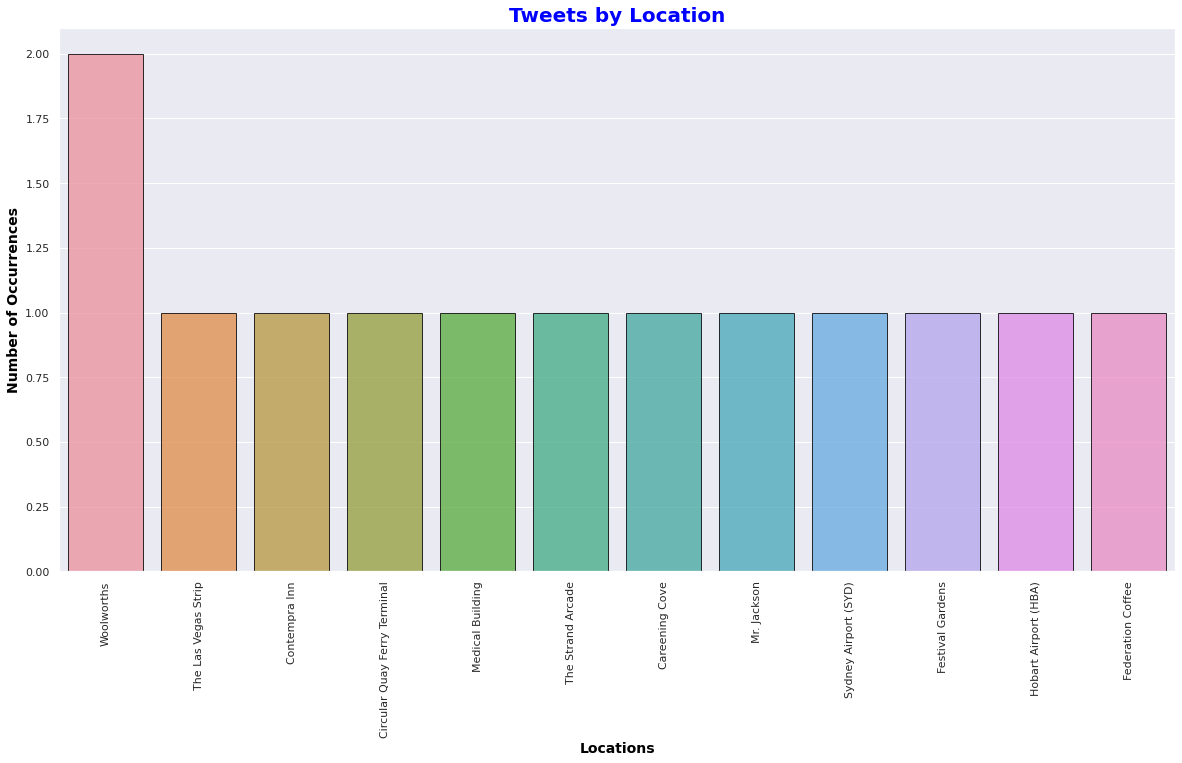

In [ ]:
#Plotting the Locations

word_count= pd.value_counts(df1['place'])
plt.figure(figsize=(20,10))
h=sns.barplot(word_count.index, word_count.values, alpha=0.8,edgecolor = 'black')
h.set_xticklabels(h.get_xticklabels(), rotation=90)


plt.title('Tweets by Location',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Occurrences', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Locations', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.show()


### Analysis of Tweet Dates

In [ ]:

# Group the twitter datasets based on the date field and get the count per each day.
df_covid_date_wise = df1.groupby(['date'])['tweet'].count().reset_index(name='tweet_count_covid').set_index('date')


In [ ]:
df_covid_date_wise.tail()

tweet_count_covid
date                         
2020-04-21                157
2020-04-22                103
2020-04-23                179
2020-04-24                120
2020-04-25                 16

<Figure size 1440x720 with 0 Axes>

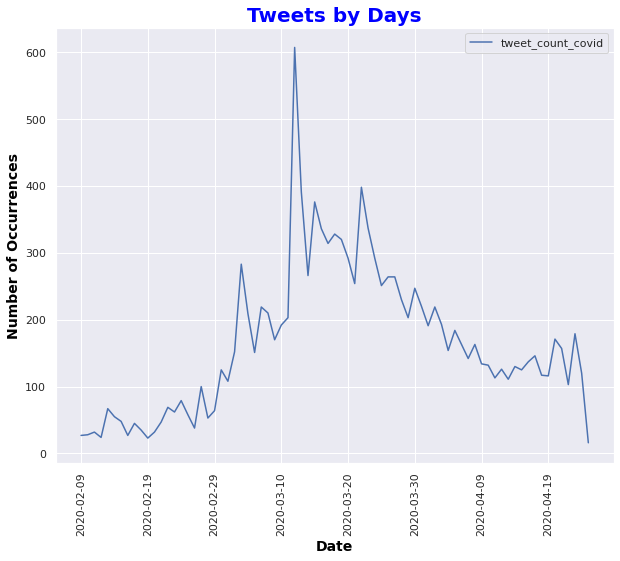

In [ ]:
# Plot twitter activity timeline.

plt.figure(figsize=(20,10))
h=df_covid_date_wise.plot()
h.set_xticklabels(h.get_xticklabels(), rotation=90)

plt.title('Tweets by Days',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Occurrences', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Date', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.show()

### Add derived date fields

Since all the tweets are in the year 2020 using months further analysis were conducted.

In [ ]:
# Create new month colum

df1['month'] = [''.join(x.split('-')[1:2]) for x in df1.date]

In [ ]:
# Group the tweets based on the month.

df1_m = df1.groupby(['month'])['tweet_lemmatized'].count().reset_index(name= 'tweet_count')

2020-05-12 03:54:07,511 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-05-12 03:54:07,513 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


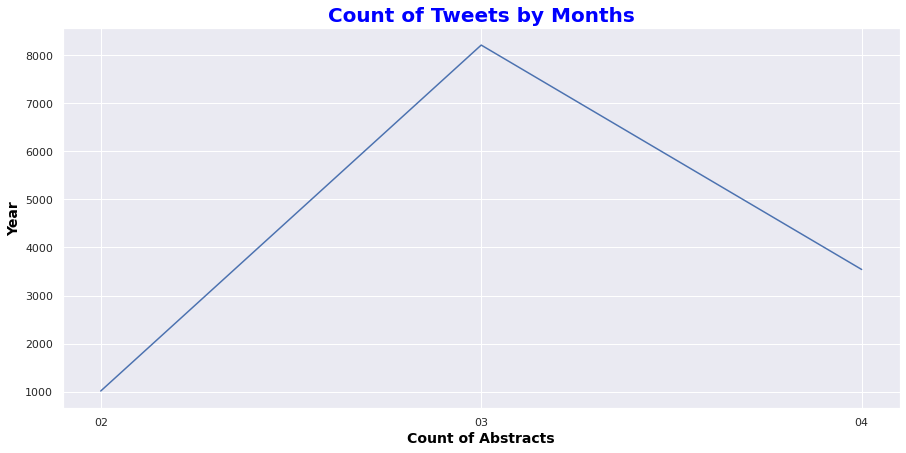

In [ ]:
plt.figure(figsize=(15, 7)) 
sns.lineplot(x="month", y="tweet_count", legend="full", data=df1_m)

plt.title('Count of Tweets by Months', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Count of Abstracts', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Year', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('temporal_analysis.png', dpi=800)
plt.show()